# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

#Loading our data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#creating validation set:
torch.manual_seed(5) #ensuring same split everytime
val_size = int(0.20 * len(trainset))
train_size = len(trainset) - val_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

print("Train set size:", len(trainset))
print("Validation set size:", len(valset))
print("Test set size:", len(testset))

Train set size: 40000
Validation set size: 10000
Test set size: 10000


In [5]:
#Dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

torch.Size([16, 3, 32, 32])
torch.Size([16])


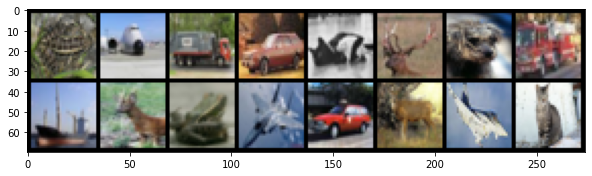

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function to display the images
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shapes of the images and labels
print(images.shape)
print(labels.shape)

# Display the images
imshow(torchvision.utils.make_grid(images))


## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [7]:
class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super(MLPAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 32*32*3),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 3, 32, 32)
        return x

class ComboAutoEncoder(nn.Module):
    def __init__(self):
        super(ComboAutoEncoder, self).__init__()
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #Shape: 32,32,8
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2), #Shape: 16,16,8
            nn.Flatten(), #Shape: 16*16*8
            nn.Linear(16*16*8, 512), #Shape: 512
            nn.ReLU(True),
            nn.Linear(512, 32), #Shape: 32
        )
        self.mlp_decoder = nn.Sequential(
            nn.Linear(32, 512), #Shape: 512
            nn.ReLU(True),
            nn.Linear(512, 16*16*8), #Shape: 16*16*8
            nn.ReLU(True),
            nn.Unflatten(1, (8, 16, 16)), #Shape: 8,16,16
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1), #Shape: 32,32,3
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_encoder(x)
        x = self.mlp_decoder(x)
        return x
    


class CNNAutoEncoder(nn.Module):
    def __init__(self):
            super(CNNAutoEncoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [8]:
import time

learning_rate = 0.0001
final_train_loss = []
final_validation_loss = []
final_test_loss = []
model_size = []
model_parameters = []
time_taken = []

model1 = MLPAutoEncoder().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

model2 = ComboAutoEncoder().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

model3 = CNNAutoEncoder().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

final_model_state = []

In [9]:
epochs = 10
for model, optimizer in [(model1, optimizer1),(model2, optimizer2),(model3, optimizer3)]:
    print("Training Model: {}".format(model.__class__.__name__))
    criterion = nn.MSELoss()
    train_loss = []
    validation_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        tra_loss = 0.0
        for data in trainloader:
            inputs, _ = data
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item() * inputs.size(0)
        train_loss.append(tra_loss / len(trainloader.dataset))
        
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss / len(trainloader.dataset)))
        model.eval()
        val_loss = 0.0
        for data in valloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        validation_loss.append(val_loss / len(valloader.dataset))
        
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss / len(valloader.dataset)))
    print("Training complete")
    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    model.eval()
    test_loss = 0.0
    for data in testloader:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)
    final_test_loss.append(test_loss / len(testloader.dataset))
    print("Test Loss: {}".format(test_loss / len(testloader.dataset)))
    # print the model size, number of parameters, and time taken per epoch
    print(f"Model Size: {sum(p.numel() for p in model.parameters())/1000000:.6f} MB")
    model_size.append(sum(p.numel() for p in model.parameters())/1000000)
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters()):,}")
    model_parameters.append(sum(p.numel() for p in model.parameters()))
    print(f"Time per Epoch: {(time.time() - start_time)/epochs:.6f} seconds")
    time_taken.append((time.time() - start_time)/epochs)
    final_model_state.append(model)

Training Model: MLPAutoEncoder
Epoch: 1, Training Loss: 0.04469464487060904
Epoch: 1, Validation Loss: 0.032841768181324005
Epoch: 2, Training Loss: 0.029504740677028893
Epoch: 2, Validation Loss: 0.02677892287671566
Epoch: 3, Training Loss: 0.025289209197089078
Epoch: 3, Validation Loss: 0.02417515377700329
Epoch: 4, Training Loss: 0.023563043411448596
Epoch: 4, Validation Loss: 0.023234181854128837
Epoch: 5, Training Loss: 0.023127347337454557
Epoch: 5, Validation Loss: 0.022767365364730358
Epoch: 6, Training Loss: 0.022401449811458588
Epoch: 6, Validation Loss: 0.02191154545992613
Epoch: 7, Training Loss: 0.02158252991177142
Epoch: 7, Validation Loss: 0.021126880100369453
Epoch: 8, Training Loss: 0.0208638954564929
Epoch: 8, Validation Loss: 0.02058591539412737
Epoch: 9, Training Loss: 0.020126872466877103
Epoch: 9, Validation Loss: 0.019776238483190538
Epoch: 10, Training Loss: 0.019709504989907145
Epoch: 10, Validation Loss: 0.019601272724568845
Training complete
Test Loss: 0.0196

In [10]:
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

GroundTruth:    cat  ship  ship plane  frog


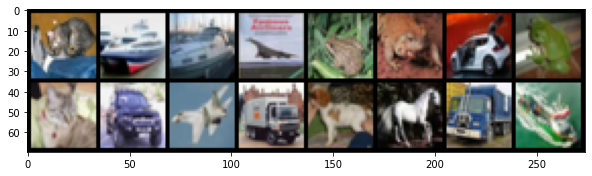

Reconstructed image


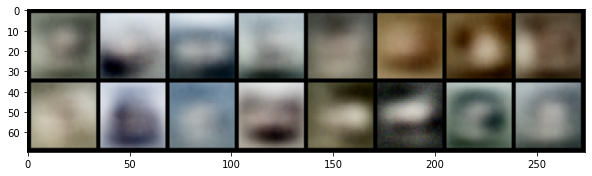

GroundTruth:    cat  ship  ship plane  frog


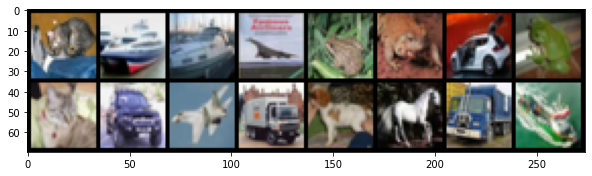

Reconstructed image


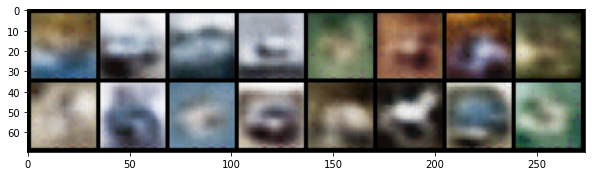

GroundTruth:    cat  ship  ship plane  frog


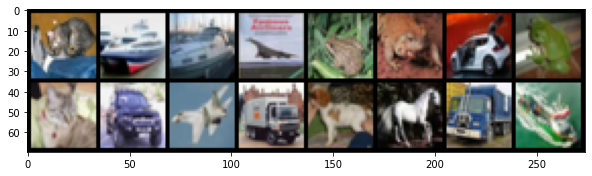

Reconstructed image


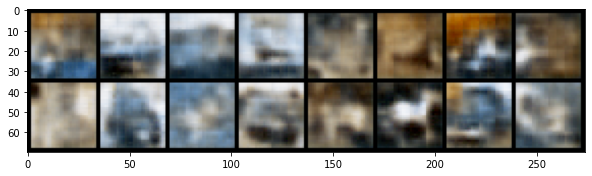

In [11]:
# Utilize the following code
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#--------------MLP--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[0](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------Combo--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[1](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------CNN--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[2](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

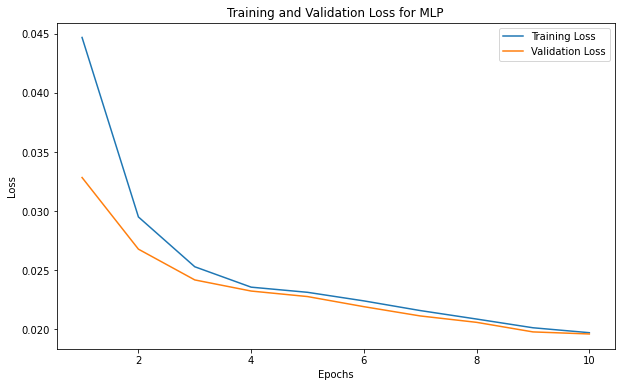

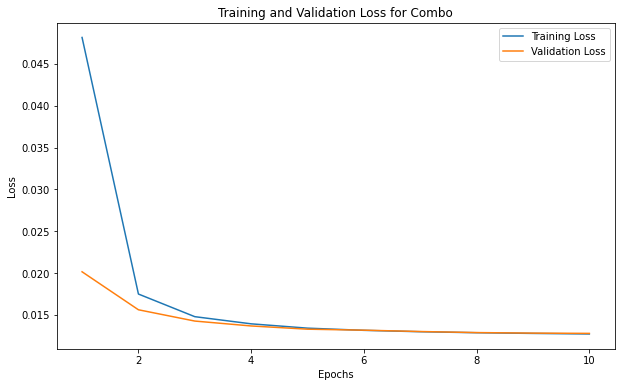

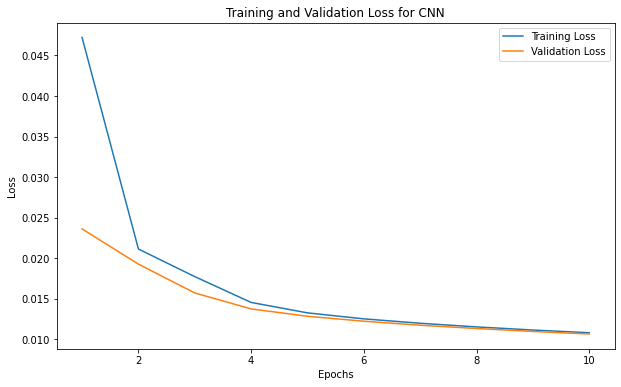

In [12]:
"""
Plotting Train and Validation Losses
"""

models = ['MLP', 'Combo', 'CNN']
for i in range(len(models)):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), final_train_loss[i], label='Training Loss')
    plt.plot(range(1, epochs+1), final_validation_loss[i], label='Validation Loss')
    plt.title('Training and Validation Loss for {}'.format(models[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


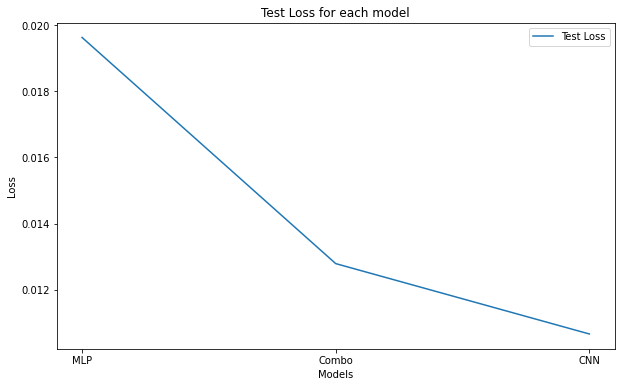

In [13]:
"""
Plotting Test Losses
"""
models = ['MLP', 'Combo', 'CNN']
plt.figure(figsize=(10, 6))
plt.plot(models, final_test_loss, label='Test Loss')
plt.title('Test Loss for each model')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
"""
Tabulating the data
"""
models = ['MLP', 'Combo', 'CNN']
finale_train_loss = [train_loss[-1] for train_loss in final_train_loss]
finale_validation_loss = [validation_loss[-1] for validation_loss in final_validation_loss]
final_test_loss = final_test_loss
model_size = model_size
model_parameters = model_parameters
time_taken = time_taken

metrics = {
    'Model': models,
    'Training Loss': finale_train_loss,
    'Validation Loss': finale_validation_loss,
    'Test Loss': final_test_loss,   
    'Model Size in MB': model_size,
    'Model Parameters': model_parameters,
    'Time per Epoch in Seconds': time_taken
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Model  Training Loss  Validation Loss  Test Loss  Model Size in MB  \
0    MLP       0.019710         0.019601   0.019634          0.810400   
1  Combo       0.012714         0.012785   0.012786          2.133467   
2    CNN       0.010819         0.010666   0.010655          0.012035   

   Model Parameters  Time per Epoch in Seconds  
0            810400                  22.427734  
1           2133467                  21.576073  
2             12035                  22.674605  


## Analysis:
1. The `CNN` architecture gives a lower test loss compared to other models.
2. On visual inspection, the `Combo` and the `CNN` give better displays and reconstructions in comparison to the `MLP`.
3. All the three models take around the same time to train (time per epoch). While `CNN` might take a few milliseconds more, I believe its worth it as it makes it up due to the kind of results it gives.
4. Another very important thing to note is that the `numper of params` and `model size` is significantly lower for `CNN` compared to other models. This means it has significantly lesser space complexity compared to the results it gives. 


### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [15]:
class CNNAutoEncoder10(nn.Module):
    def __init__(self):
            super(CNNAutoEncoder10, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(5, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(8, 10, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(10, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 5, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(5, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CNNAutoEncoder32(nn.Module):
    def __init__(self):
            super(CNNAutoEncoder32, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CNNAutoEncoder100(nn.Module):
    def __init__(self):
            super(CNNAutoEncoder100, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 100, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(100, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CNNAutoEncoder1000(nn.Module):
    def __init__(self):
            super(CNNAutoEncoder1000, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(256, 1000, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(1000, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
import time

learning_rate = 0.0001
final_train_loss = []
final_validation_loss = []
final_test_loss = []
model_size = []
model_parameters = []
time_taken = []

model1 = CNNAutoEncoder10().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

model2 = CNNAutoEncoder32().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

model3 = CNNAutoEncoder100().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

model4 = CNNAutoEncoder1000().to(device)
optimizer4 = optim.Adam(model4.parameters(), lr=learning_rate)

final_model_state = []

In [17]:
epochs = 5
for model, optimizer in [(model1, optimizer1),(model2, optimizer2),(model3, optimizer3),(model4, optimizer4)]:
    print("Training Model: {}".format(model.__class__.__name__))
    criterion = nn.MSELoss()
    train_loss = []
    validation_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        tra_loss = 0.0
        for data in trainloader:
            inputs, _ = data
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item() * inputs.size(0)
        train_loss.append(tra_loss / len(trainloader.dataset))
        
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss / len(trainloader.dataset)))
        model.eval()
        val_loss = 0.0
        for data in valloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        validation_loss.append(val_loss / len(valloader.dataset))
        
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss / len(valloader.dataset)))
    print("Training complete")
    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    model.eval()
    test_loss = 0.0
    for data in testloader:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)
    final_test_loss.append(test_loss / len(testloader.dataset))
    print("Test Loss: {}".format(test_loss / len(testloader.dataset)))
    # print the model size, number of parameters, and time taken per epoch
    print(f"Model Size: {sum(p.numel() for p in model.parameters())/1000000:.6f} MB")
    model_size.append(sum(p.numel() for p in model.parameters())/1000000)
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters()):,}")
    model_parameters.append(sum(p.numel() for p in model.parameters()))
    print(f"Time per Epoch: {(time.time() - start_time)/epochs:.6f} seconds")
    time_taken.append((time.time() - start_time)/epochs)
    final_model_state.append(model)

Training Model: CNNAutoEncoder10
Epoch: 1, Training Loss: 0.08167735032215714
Epoch: 1, Validation Loss: 0.029434887179732323
Epoch: 2, Training Loss: 0.02609353472441435
Epoch: 2, Validation Loss: 0.023879745039343835
Epoch: 3, Training Loss: 0.022789055275171995
Epoch: 3, Validation Loss: 0.02173215848207474
Epoch: 4, Training Loss: 0.021090705208107827
Epoch: 4, Validation Loss: 0.020492604905366897
Epoch: 5, Training Loss: 0.020097621133551003
Epoch: 5, Validation Loss: 0.019688253308832646
Training complete
Test Loss: 0.019711281655728816
Model Size: 0.002469 MB
Number of Parameters: 2,469
Time per Epoch: 23.172273 seconds
Training Model: CNNAutoEncoder32
Epoch: 1, Training Loss: 0.051895931454375384
Epoch: 1, Validation Loss: 0.022279460924863815
Epoch: 2, Training Loss: 0.020103323937952517
Epoch: 2, Validation Loss: 0.018627567771077155
Epoch: 3, Training Loss: 0.01778673909343779
Epoch: 3, Validation Loss: 0.01700515218526125
Epoch: 4, Training Loss: 0.015814428451284765
Epoch

GroundTruth:    cat  ship  ship plane  frog


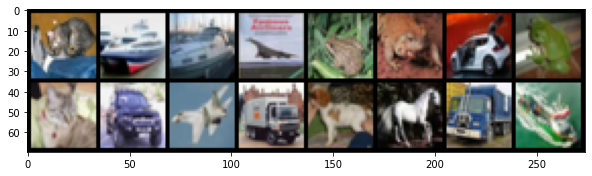

Reconstructed image


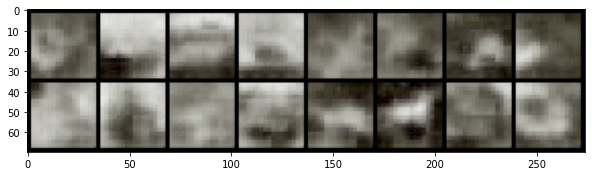

GroundTruth:    cat  ship  ship plane  frog


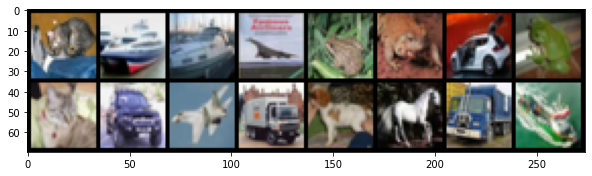

Reconstructed image


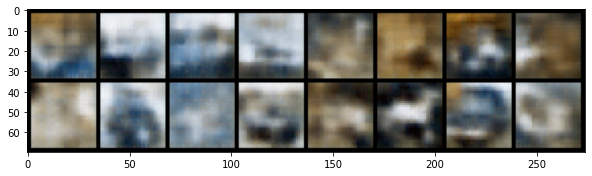

GroundTruth:    cat  ship  ship plane  frog


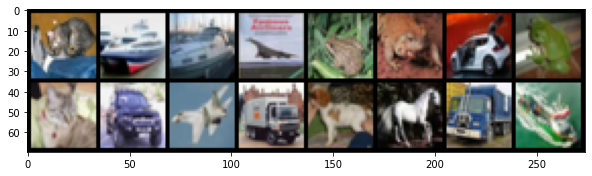

Reconstructed image


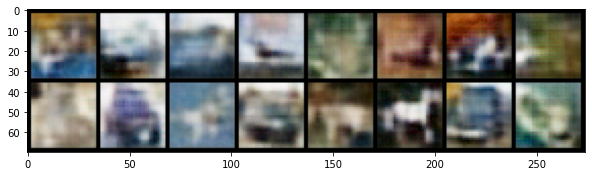

GroundTruth:    cat  ship  ship plane  frog


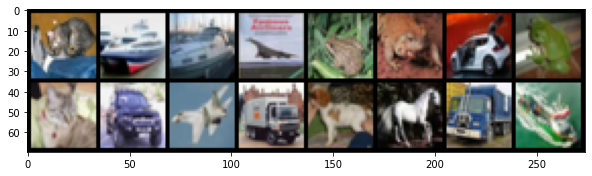

Reconstructed image


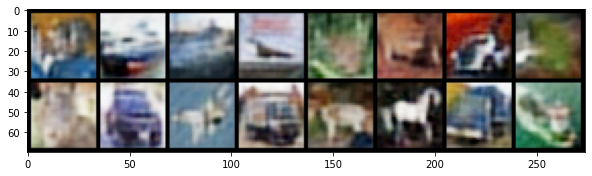

In [18]:
# Utilize the following code
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#--------------10--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[0](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------32--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[1](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------100--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[2](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------1000--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[3](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

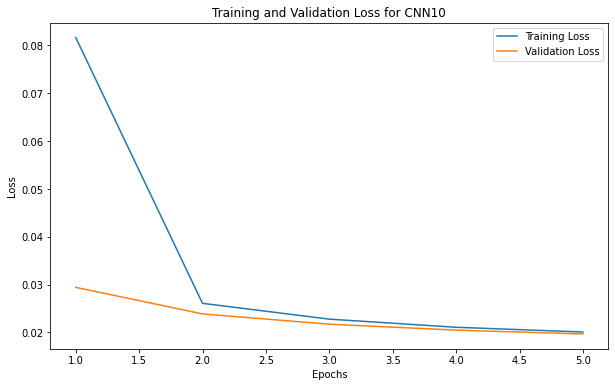

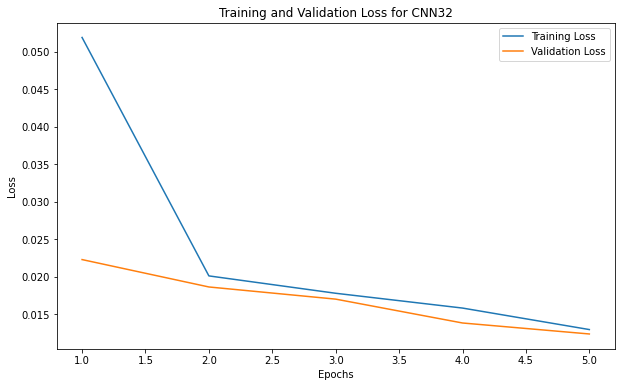

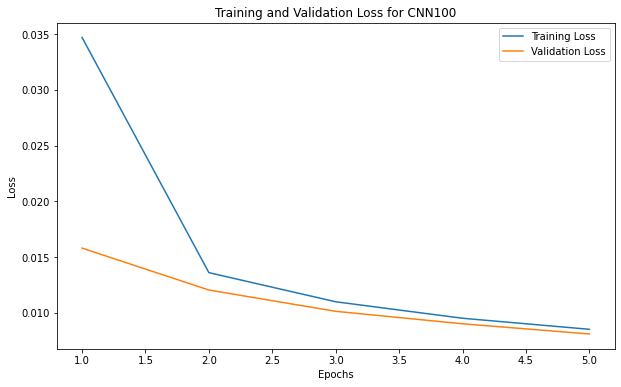

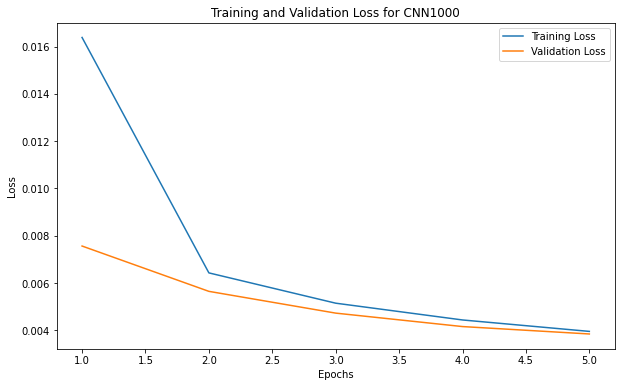

In [19]:
"""
Plotting Train and Validation Losses
"""

models = ['CNN10', 'CNN32', 'CNN100', 'CNN1000']
for i in range(len(models)):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), final_train_loss[i], label='Training Loss')
    plt.plot(range(1, epochs+1), final_validation_loss[i], label='Validation Loss')
    plt.title('Training and Validation Loss for {}'.format(models[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


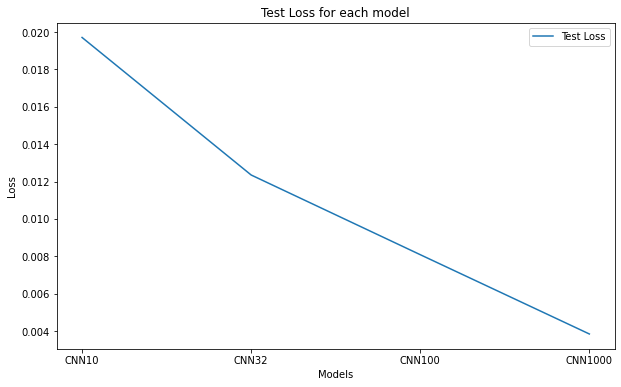

In [20]:
"""
Plotting Test Losses
"""
models = ['CNN10', 'CNN32', 'CNN100', 'CNN1000']
plt.figure(figsize=(10, 6))
plt.plot(models, final_test_loss, label='Test Loss')
plt.title('Test Loss for each model')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
"""
Tabulating the data
"""
models = ['CNN10', 'CNN32', 'CNN100', 'CNN1000']
finale_train_loss = [train_loss[-1] for train_loss in final_train_loss]
finale_validation_loss = [validation_loss[-1] for validation_loss in final_validation_loss]
final_test_loss = final_test_loss
model_size = model_size
model_parameters = model_parameters
time_taken = time_taken

metrics = {
    'Model': models,
    'Training Loss': finale_train_loss,
    'Validation Loss': finale_validation_loss,
    'Test Loss': final_test_loss,   
    'Model Size in MB': model_size,
    'Model Parameters': model_parameters,
    'Time per Epoch in Seconds': time_taken
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

     Model  Training Loss  Validation Loss  Test Loss  Model Size in MB  \
0    CNN10       0.020098         0.019688   0.019711          0.002469   
1    CNN32       0.012947         0.012360   0.012351          0.012035   
2   CNN100       0.008511         0.008092   0.008087          0.067879   
3  CNN1000       0.003959         0.003850   0.003844          4.758763   

   Model Parameters  Time per Epoch in Seconds  
0              2469                  23.172278  
1             12035                  23.084112  
2             67879                  23.012467  
3           4758763                  36.853321  


## Analysis:
1. Based on visual inspection, the representation size of $1000$ gives the best results. 
2. However, the representation size of $100$ isn't far off from the output, it gives decent results.
3. The `1000` representation size occupies alot more space and total parameters as well can see above, This trade off doesn't feel worth it compared to the `100` representation size model. 

I think that keeping the representation size somewhere around `500` seems optimal to get a decent reconstructed image and at the same time ensure appropriate time and space complexity.


### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [22]:
class CNNAutoEncoderL1(nn.Module):
    def __init__(self):
            super(CNNAutoEncoderL1, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), 
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2), 
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1), 
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CNNAutoEncoderL3(nn.Module):
    def __init__(self):
            super(CNNAutoEncoderL3, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CNNAutoEncoderL5(nn.Module):
    def __init__(self):
            super(CNNAutoEncoderL5, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class CNNAutoEncoderL10(nn.Module):
    def __init__(self):
            super(CNNAutoEncoderL10, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #shape: (8, 32, 32)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2), #shape: (8, 16, 16)
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #shape: (16, 16, 16)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=1, stride=1), #shape: (16, 16, 16)
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #shape: (32, 16, 16)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2), #shape: (32, 8, 8)
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #shape: (64, 8, 8)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=1, stride=1), #shape: (64, 8, 8)
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #shape: (128, 8, 8)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2), #shape: (128, 4, 4)
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #shape: (256, 4, 4)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=1, stride=1), #shape: (256, 4, 4)
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), #shape: (512, 4, 4)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2), #shape: (512, 2, 2)
                nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), #shape: (1024, 2, 2)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=1, stride=1), #shape: (1024, 2, 2)
                nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1), #shape: (2048, 2, 2)
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2), #shape: (2048, 1, 1)
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1), #shape: (1024, 2, 2)
                nn.ReLU(True),
                nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=1, padding=1), #shape: (512, 2, 2)
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), #shape: (256, 4, 4)
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1), #shape: (128, 4, 4)
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), #shape: (64, 8, 8)
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1), #shape: (32, 8, 8)
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), #shape: (16, 16, 16)
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1), #shape: (8, 16, 16)
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1), #shape: (3, 32, 32)
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
import time

learning_rate = 0.0001
final_train_loss = []
final_validation_loss = []
final_test_loss = []
model_size = []
model_parameters = []
time_taken = []

model1 = CNNAutoEncoderL1().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

model2 = CNNAutoEncoderL3().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

model3 = CNNAutoEncoderL5().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

model4 = CNNAutoEncoderL10().to(device)
optimizer4 = optim.Adam(model4.parameters(), lr=learning_rate)

final_model_state = []

In [24]:
epochs = 5
for model, optimizer in [(model1, optimizer1),(model2, optimizer2),(model3, optimizer3),(model4, optimizer4)]:
    print("Training Model: {}".format(model.__class__.__name__))
    criterion = nn.MSELoss()
    train_loss = []
    validation_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        tra_loss = 0.0
        for data in trainloader:
            inputs, _ = data
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item() * inputs.size(0)
        train_loss.append(tra_loss / len(trainloader.dataset))
        
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss / len(trainloader.dataset)))
        model.eval()
        val_loss = 0.0
        for data in valloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        validation_loss.append(val_loss / len(valloader.dataset))
        
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss / len(valloader.dataset)))
    print("Training complete")
    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    model.eval()
    test_loss = 0.0
    for data in testloader:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)
    final_test_loss.append(test_loss / len(testloader.dataset))
    print("Test Loss: {}".format(test_loss / len(testloader.dataset)))
    # print the model size, number of parameters, and time taken per epoch
    print(f"Model Size: {sum(p.numel() for p in model.parameters())/1000000:.6f} MB")
    model_size.append(sum(p.numel() for p in model.parameters())/1000000)
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters()):,}")
    model_parameters.append(sum(p.numel() for p in model.parameters()))
    print(f"Time per Epoch: {(time.time() - start_time)/epochs:.6f} seconds")
    time_taken.append((time.time() - start_time)/epochs)
    final_model_state.append(model)

Training Model: CNNAutoEncoderL1
Epoch: 1, Training Loss: 0.06327923280745745
Epoch: 1, Validation Loss: 0.01482794543504715
Epoch: 2, Training Loss: 0.012379855041764677
Epoch: 2, Validation Loss: 0.009850262628495693
Epoch: 3, Training Loss: 0.007912562272883951
Epoch: 3, Validation Loss: 0.006858480478823185
Epoch: 4, Training Loss: 0.006391488752979785
Epoch: 4, Validation Loss: 0.005935501440614462
Epoch: 5, Training Loss: 0.0055817675932310525
Epoch: 5, Validation Loss: 0.005246903378516436
Training complete
Test Loss: 0.0052595458447933195
Model Size: 0.000443 MB
Number of Parameters: 443
Time per Epoch: 17.975391 seconds
Training Model: CNNAutoEncoderL3
Epoch: 1, Training Loss: 0.053291075146198276
Epoch: 1, Validation Loss: 0.023240818990767003
Epoch: 2, Training Loss: 0.020784939866513013
Epoch: 2, Validation Loss: 0.019123161764442922
Epoch: 3, Training Loss: 0.01822583494745195
Epoch: 3, Validation Loss: 0.017394680370390415
Epoch: 4, Training Loss: 0.016789752684533595
Epo

GroundTruth:    cat  ship  ship plane  frog


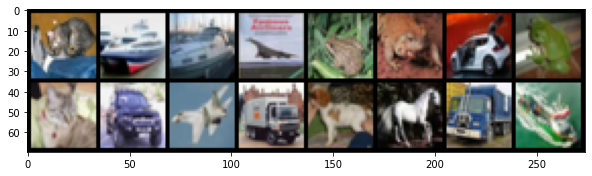

Reconstructed image


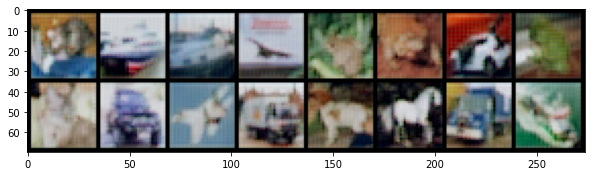

GroundTruth:    cat  ship  ship plane  frog


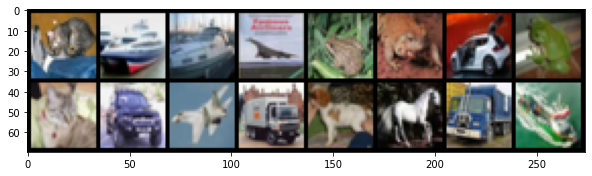

Reconstructed image


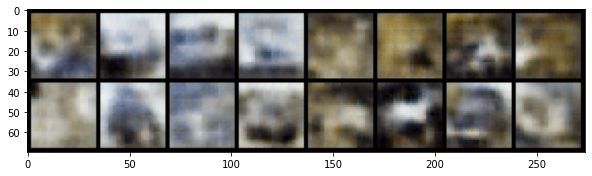

GroundTruth:    cat  ship  ship plane  frog


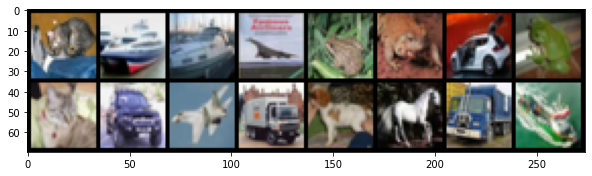

Reconstructed image


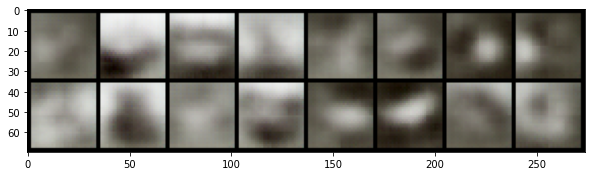

GroundTruth:    cat  ship  ship plane  frog


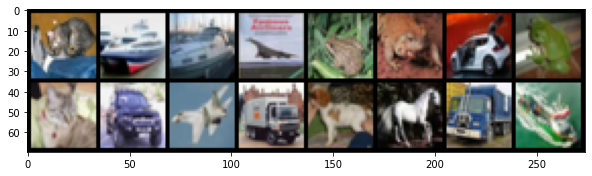

Reconstructed image


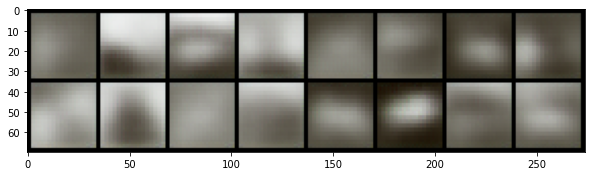

In [25]:
# Utilize the following code
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#--------------10--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[0](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------32--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[1](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------100--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[2](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------1000--------------#
dataiter = iter(testloader)
images, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = images.to(device)

print("Reconstructed image")
decoded_imgs = final_model_state[3](images).cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

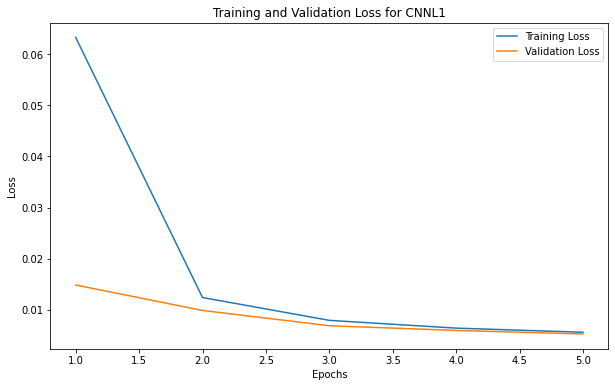

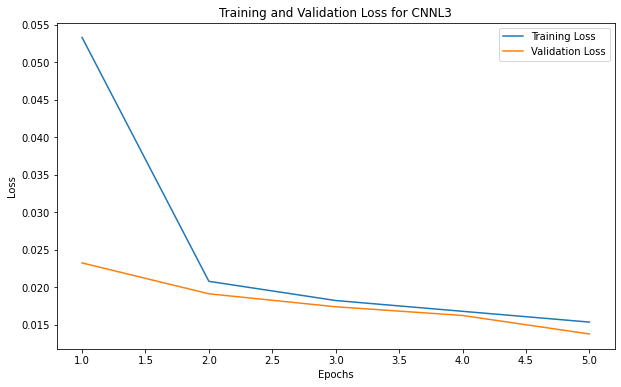

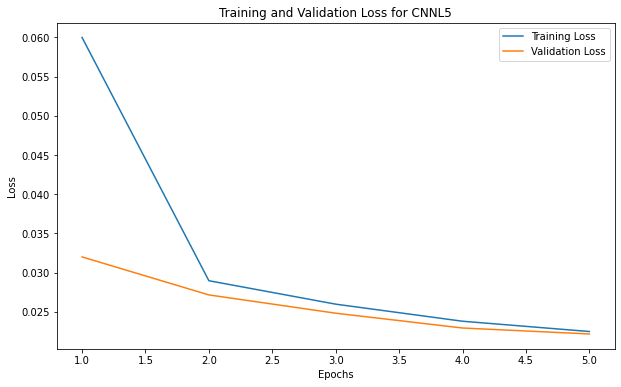

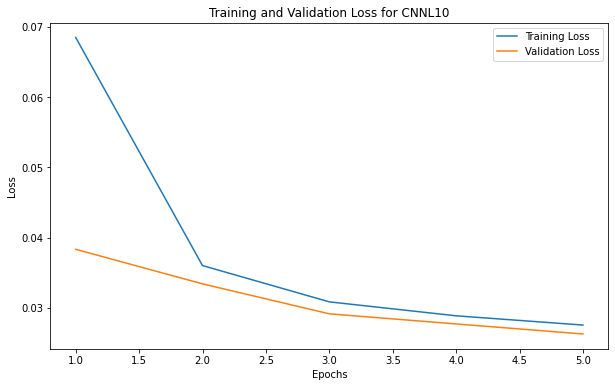

In [26]:
"""
Plotting Train and Validation Losses
"""

models = ['CNNL1', 'CNNL3', 'CNNL5', 'CNNL10']
for i in range(len(models)):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), final_train_loss[i], label='Training Loss')
    plt.plot(range(1, epochs+1), final_validation_loss[i], label='Validation Loss')
    plt.title('Training and Validation Loss for {}'.format(models[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


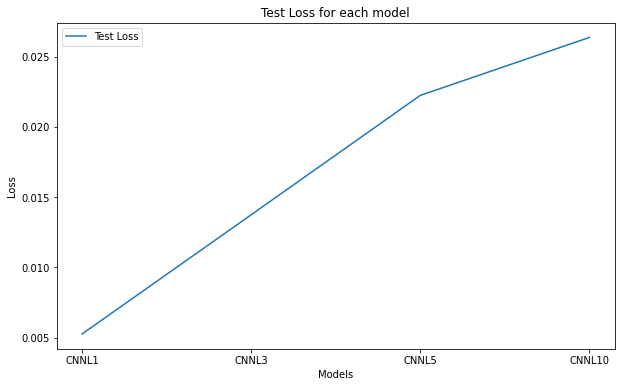

In [27]:
"""
Plotting Test Losses
"""
models = ['CNNL1', 'CNNL3', 'CNNL5', 'CNNL10']
plt.figure(figsize=(10, 6))
plt.plot(models, final_test_loss, label='Test Loss')
plt.title('Test Loss for each model')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
"""
Tabulating the data
"""
models = ['CNNL1', 'CNNL3', 'CNNL5', 'CNNL10']
finale_train_loss = [train_loss[-1] for train_loss in final_train_loss]
finale_validation_loss = [validation_loss[-1] for validation_loss in final_validation_loss]
final_test_loss = final_test_loss
model_size = model_size
model_parameters = model_parameters
time_taken = time_taken

metrics = {
    'Model': models,
    'Training Loss': finale_train_loss,
    'Validation Loss': finale_validation_loss,
    'Test Loss': final_test_loss,   
    'Model Size in MB': model_size,
    'Model Parameters': model_parameters,
    'Time per Epoch in Seconds': time_taken
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

    Model  Training Loss  Validation Loss  Test Loss  Model Size in MB  \
0   CNNL1       0.005582         0.005247   0.005260          0.000443   
1   CNNL3       0.015352         0.013767   0.013740          0.012035   
2   CNNL5       0.022494         0.022180   0.022236          0.196643   
3  CNNL10       0.027538         0.026269   0.026360         50.337443   

   Model Parameters  Time per Epoch in Seconds  
0               443                  17.975397  
1             12035                  23.036078  
2            196643                  28.847323  
3          50337443                 165.436794  


## Analysis:

1. Based on visual inspection, we clearly see that having 10 layers doesnt do us any good as the reconstructed image is of extremely poor quality and and model size, the total model parameters as well time taken is abormally high. This indicates that its overall not good to have a model with large number of layers.
2. The optimal outputs visually and time and space complexity wise are given by 1 and 3 layers. This leads us to believe that an overall smaller model architecture gives better results compared to a larger one. 

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

## About AutoEncoders:
An autoencoder is a form of neural network design that develops its own unsupervised learning methods for learning how to compress and decompress data. It is a kind of neural network made up of a network of encoders and decoders.

An autoencoder's objective is to discover a compressed representation of the input data that captures its key characteristics. While the decoder network learns to reconstruct the input data from the bottleneck, the encoder network gains knowledge on how to compress the input data into the bottleneck. Backpropagation, which modifies the neural network's weights to reduce the discrepancy between the original input data and the reconstructed output, is used to train the parameters of the autoencoder.

As discussed above, techniques for dimensionality reduction and feature extraction include autoencoders, PCA, t-SNE, and variational autoencoders (VAEs). They do this duty differently and are better suited for different kinds of difficulties, though.

## Comparisons:

A linear dimensionality reduction technique called **principal component analysis (PCA)** projects high-dimensional data into a lower-dimensional space while retaining as much of the original variation as possible. PCA is effective in identifying the predominant axes of variation in the data, but it is unable to detect intricate non-linear correlations.

The non-linear dimensionality reduction method known as **t-SNE (t-Distributed Stochastic Neighbor Embedding)** is particularly beneficial for presenting high-dimensional data in low-dimensional space. By reducing the difference between the pairwise similarities of the high-dimensional and low-dimensional data, it achieves its desired results. High-dimensional data are not a good fit for t-SNE since it is computationally expensive and poor at retaining local structures and capturing non-linear correlations.

An autoencoder called a **variational autoencoder (VAE)** creates new data points that are similar to the original data by using probabilistic latent variables. New data points are created using VAEs, which are also utilised for unsupervised learning tasks like data grouping and anomaly detection. Complex non-linear interactions can be accurately captured by VAEs, which can also provide new data points that are identical to the original data.

**To summarize:**
1. Using unsupervised learning approaches, autoencoders are a sort of neural network design that can learn to compress and decompress data.
2. Autoencoders may learn non-linear representations of the data and can handle complex, high-dimensional data, in contrast to PCA and t-SNE.
3. Autoencoders are more adaptable than PCA and t-SNE since they may be utilised for tasks like picture synthesis and anomaly detection.
4. Autoencoders can be expensive to compute and need a lot of data to train well.

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [48]:
class CNNAutoEncoder10(nn.Module):
    def __init__(self):
            super(CNNAutoEncoder10, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(5, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(8, 10, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(10, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 5, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(5, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = CNNAutoEncoder10().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    
    # Training loop
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed_data = model(data)
        loss = criterion(reconstructed_data, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # Validation loop
    with torch.no_grad():
        for data, _ in valloader:
            data = data.to(device)
            reconstructed_data = model(data)
            loss = criterion(reconstructed_data, data)
            val_loss += loss.item()
    
    # Calculate average loss
    train_loss /= len(trainloader.dataset)
    val_loss /= len(valloader.dataset)
    
    # Print progress
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, val_loss))
    
# Test loop
with torch.no_grad():
    test_loss = 0
    for data, _ in testloader:
        data = data.to(device)
        reconstructed_data = model(data)
        loss = criterion(reconstructed_data, data)
        test_loss += loss.item()
    test_loss /= len(testloader.dataset)
    print('Test Loss: {:.4f}'.format(test_loss))

Epoch [1/10], Train Loss: 0.0047, Val Loss: 0.0020
Epoch [2/10], Train Loss: 0.0018, Val Loss: 0.0017
Epoch [3/10], Train Loss: 0.0015, Val Loss: 0.0014
Epoch [4/10], Train Loss: 0.0013, Val Loss: 0.0013
Epoch [5/10], Train Loss: 0.0013, Val Loss: 0.0012
Epoch [6/10], Train Loss: 0.0012, Val Loss: 0.0012
Epoch [7/10], Train Loss: 0.0012, Val Loss: 0.0011
Epoch [8/10], Train Loss: 0.0011, Val Loss: 0.0011
Epoch [9/10], Train Loss: 0.0011, Val Loss: 0.0011
Epoch [10/10], Train Loss: 0.0011, Val Loss: 0.0011
Test Loss: 0.0011


In [50]:
def get_embedding(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            output = model.encoder(data)
            embeddings.append(output.cpu().numpy())
            labels.append(target.numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

train_embeddings, train_labels = get_embedding(model, trainloader)
test_embeddings, test_labels = get_embedding(model, testloader)
print(train_embeddings.shape, test_embeddings.shape)
print(train_labels.shape, test_labels.shape)

(40000, 10, 4, 4) (10000, 10, 4, 4)
(40000,) (10000,)


In [51]:
train_embeddings = train_embeddings.reshape(40000, -1) 
test_embeddings = test_embeddings.reshape(10000, -1)
print(train_embeddings.shape, test_embeddings.shape)

(40000, 160) (10000, 160)


In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_embeddings, train_labels)
y_pred = knn.predict(test_embeddings)

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('Accuracy: {:.2f}'.format(accuracy_score(test_labels, y_pred)))
print(classification_report(test_labels, y_pred))

Accuracy: 0.37
              precision    recall  f1-score   support

           0       0.31      0.55      0.40      1000
           1       0.49      0.37      0.42      1000
           2       0.27      0.36      0.31      1000
           3       0.31      0.15      0.20      1000
           4       0.28      0.41      0.33      1000
           5       0.47      0.29      0.36      1000
           6       0.35      0.44      0.39      1000
           7       0.54      0.33      0.41      1000
           8       0.44      0.56      0.49      1000
           9       0.58      0.25      0.35      1000

    accuracy                           0.37     10000
   macro avg       0.40      0.37      0.37     10000
weighted avg       0.40      0.37      0.37     10000



## Analysis:

We clearly see that we do not get great results from using KNN Classifier on the encoder representations (embeddings). Some speculations as to why can be regarding the value of $K$ used, the amount of training data available, imbalance among the classes in the dataset etc. 

Compared to the AutoEncoders, KNN is a non-parametric technique used to predict the label of the input data point. It compares the distance between the input data point and its $k$ nearest neighbours in the feature space. 

Autoencoders are better suited for tasks that require feature learning or when the data has a complex structure or high dimensionality, while kNN is better suited for simple classification tasks with small feature spaces and well-separated data.


## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."